# Working with XDF data using MNE
The goal of this notebook is to import data saved using the LSL Lab Recorder, and run through some pre-processing steps using [MNE-Python](https://mne.tools/stable/index.html)!

In [1]:
import mne
import matplotlib
# matplotlib.use("Qt5Agg")
import matplotlib.pyplot as plt
import pyxdf
import numpy as np
import time
from scipy.signal import butter, lfilter, iirnotch, filtfilt
from meegkit import dss
from meegkit.utils import fold, rms, tscov, unfold
import librosa # optional, only needed to convert MIDI keys to notes

## Path to dataset

In [2]:
condition = 'diverse-wrong'
DATA_PATH = f'/Volumes/GoogleDrive/.shortcut-targets-by-id/1mvHxk9Ra9K7MmjQxaRYiZKwUw4Y8o841/AC23/DATA/active_piano/sub-matthias/ses-S001/{condition}/'
DATA_PATH+= f'sub-matthias_ses-S001_task-Default_run-001_{condition}.xdf'

#DATA_PATH = r'/Volumes/GoogleDrive/.shortcut-targets-by-id/1mvHxk9Ra9K7MmjQxaRYiZKwUw4Y8o841/AC23/DATA/active_piano/sub-matthias/ses-S001/diverse/'
#DATA_PATH+= 'sub-matthias_ses-S001_task-Default_run-001_diverse.xdf'

In [3]:
# Read in the LSL streams from the XDF file
START_TIME = time.time()
streams, header = pyxdf.load_xdf(DATA_PATH) # this could take ~80 seconds..
print(f'Loaded in {time.time() - START_TIME} s')

Loaded in 67.14845705032349 s


## Check the duration of each recorded stream

In [4]:
for s in streams:
    name = s['info']['name']
    
    # the footer timestamps might be coming from different machines?
    first_timestamp = float(s['footer']['info']['first_timestamp'][0])
    last_timestamp = float(s['footer']['info']['last_timestamp'][0])
    print(name, first_timestamp, last_timestamp, last_timestamp -first_timestamp)
    
    # These seem more comparable
    print(s['time_stamps'][0])

['CGX Quick-32r Q32r-0524 Impedance'] 629107.4464764 629786.0089744 678.5624979999848
629107.376903456
['CGX Quick-32r Q32r-0524'] 629107.4464736 629786.0089742 678.5625006000046
629107.3769039948
['glove_data'] 19560.898203049 20239.471641428 678.5734383790004
629107.4410032643
['MIDIStream'] 19576.212527043 20187.340799252 611.128272209
629122.755649534
['ev_ts'] 28993.876659933 29671.97202192 678.0953619869979
629107.5798429272
['MyAudioStream'] 629107.5272584757 629786.0682443557 678.5409858800704
629107.4622192689


In [5]:
# Get the first time stamp across all streams (read from time_stamps)
first_timestamps = []

for s in streams: # loop through remaining streams
    s_name = s['info']['name']
    t0 = s['time_stamps'][0]
    print(t0, '\t', s_name)
    
    first_timestamps.append(t0)
    
first_timestamp = min(first_timestamps)
print(first_timestamp, '\t', '<== earliest')   

629107.376903456 	 ['CGX Quick-32r Q32r-0524 Impedance']
629107.3769039948 	 ['CGX Quick-32r Q32r-0524']
629107.4410032643 	 ['glove_data']
629122.755649534 	 ['MIDIStream']
629107.5798429272 	 ['ev_ts']
629107.4622192689 	 ['MyAudioStream']
629107.376903456 	 <== earliest


# Collect stream info and data

In [6]:
lsl_streams = {} # for collecting time stamps and data

# Identify EEG data and impedance streams separately to collect metadata (channel names, etc)
# Remaining streams are collected in one dict

for s in streams:
    s_name = s['info']['name'][0]
    s_type = s['info']['type'][0]
    print(f'Stream Name: {s_name}\tType: {s_type}')
    print('-'*50)
    
    # Get the EEG data stream for CGX
    if ('CGX' in s_name) and (s_type == 'EEG'):
        eeg_data = s['time_series']
        eeg_t = s['time_stamps'] - first_timestamp # offset first time stamp to t=0
        eeg_ch_names = [ch['label'][0] for ch in s['info']['desc'][0]['channels'][0]['channel']]
        eeg_ch_units = [ch['unit'][0] for ch in s['info']['desc'][0]['channels'][0]['channel']]
        eeg_sfreq = s['info']['effective_srate']
        print(f'Channels: {eeg_ch_names}')
        print(f'Unit: {eeg_ch_units}')
        print(f'Eff. Sampling Rate: {eeg_sfreq} Hz')
        
    # Get the impedance data stream for CGX
    elif ('CGX' in s_name) and (s_type == 'Impeadance'): # typo in the stream name?
        z_data = s['time_series']
        z_t = s['time_stamps'] - first_timestamp
        z_ch_names = [ch['label'][0] for ch in s['info']['desc'][0]['channels'][0]['channel']]
        z_ch_units = [ch['unit'][0] for ch in s['info']['desc'][0]['channels'][0]['channel']]
        z_sfreq = s['info']['effective_srate']
        print(f'Channels: {z_ch_names}')
        print(f'Unit: {z_ch_units}')
        print(f'Eff. Sampling Rate: {z_sfreq} Hz')
        
    # Misc streams
    else:
        lsl_streams[s_type] = {}
        lsl_streams[s_type]['data'] = s['time_series']
        lsl_streams[s_type]['time'] = s['time_stamps'] - first_timestamp
        print('shape:', lsl_streams[s_type]['data'].shape)
        
    print('='*50)

Stream Name: CGX Quick-32r Q32r-0524 Impedance	Type: Impeadance
--------------------------------------------------
Channels: ['AF7-Z', 'Fpz-Z', 'F7-Z', 'Fz-Z', 'T7-Z', 'FC6-Z', 'Fp1-Z', 'F4-Z', 'C4-Z', 'Oz-Z', 'CP6-Z', 'Cz-Z', 'PO8-Z', 'CP5-Z', 'O2-Z', 'O1-Z', 'P3-Z', 'P4-Z', 'P7-Z', 'P8-Z', 'Pz-Z', 'PO7-Z', 'T8-Z', 'C3-Z', 'Fp2-Z', 'F3-Z', 'F8-Z', 'FC5-Z', 'AF8-Z', 'A2-Z', 'ExG 1-Z', 'ExG 2-Z', 'ACC32-Z', 'ACC33-Z', 'ACC34-Z', 'Packet Counter-Z', 'TRIGGER-Z']
Unit: ['kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms']
Eff. Sampling Rate: 499.8181671673822 Hz
Stream Name: CGX Quick-32r Q32r-0524	Type: EEG
--------------------------------------------------
Channels: ['AF7', 'Fpz', 'F7', 'Fz', 'T7', 'FC6', 'Fp1',

In [7]:
print(sum(eeg_data[:, -1]>0)) # number of events in trigger channel
np.unique(eeg_data[:, -1]) # types of trigger events seen

71973


array([    0.,  8192., 16384., 24576.], dtype=float32)

Event | Description
:-- | --:
Audio Left | 8192
Audio Right | 16384
Audio Left+Right | 24576

(is the mic outputting stereo?)

# Prepare to import data to mne

## Rescale EEG data to V
(only run this once!)

In [8]:
print(eeg_data[:, 0])

# Rescale units of eeg_data to V
if 'microvolts' in eeg_ch_units:
    eeg_data[:, :32] /= 1e6 # only rescale EEG and ExG channels
    
print(eeg_data[:, 0])

[-36287.305 -36281.086 -36281.062 ... -40194.664 -40193.46  -40184.98 ]
[-0.0362873  -0.03628109 -0.03628106 ... -0.04019466 -0.04019346
 -0.04018498]


(Manually) Identify each channel's type for importing data to mne:

In [9]:
ch_types = []
ch_types.extend(['eeg']*30) # first 30 channels are EEG (including A2)
ch_types.extend(['emg']*(2)) # ExG x2, ACC x3, Packet Counter)
ch_types.extend(['misc']*(3+1)) # ExG x2, ACC x3, Packet Counter)
ch_types.extend(['stim']) # Trigger channel (probably unused)

Make an info object for importing data to mne:

https://mne.tools/stable/generated/mne.create_info.html

In [10]:
info = mne.create_info(
    ch_names = eeg_ch_names,
    sfreq = eeg_sfreq,
    ch_types = ch_types,
)

Import the data as a raw array:

https://mne.tools/stable/generated/mne.io.RawArray.html

In [11]:
raw = mne.io.RawArray(
    data = eeg_data.T, # mne expects (n_channels, n_times)
    info = info,
)

raw

Creating RawArray with float64 data, n_channels=37, n_times=339269
    Range : 0 ... 339268 =      0.000 ...   678.783 secs
Ready.


<RawArray | 37 x 339269 (678.8 s), ~95.8 MB, data loaded>

## Apply the 10-20 channel montage

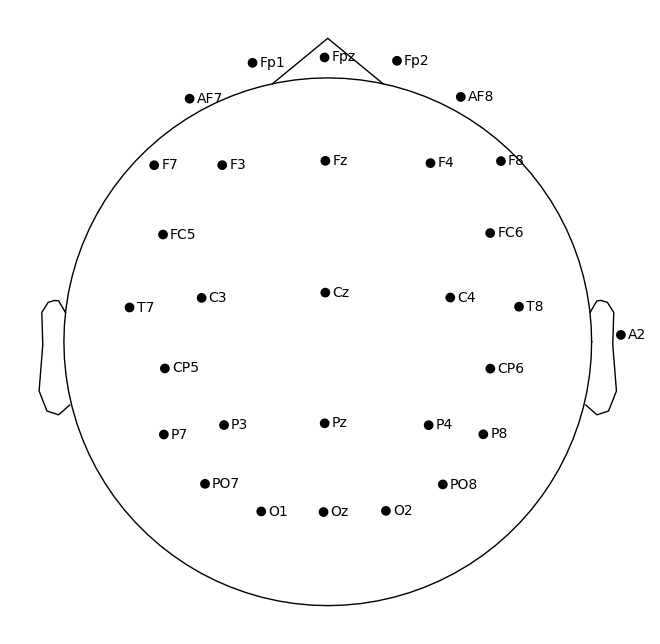

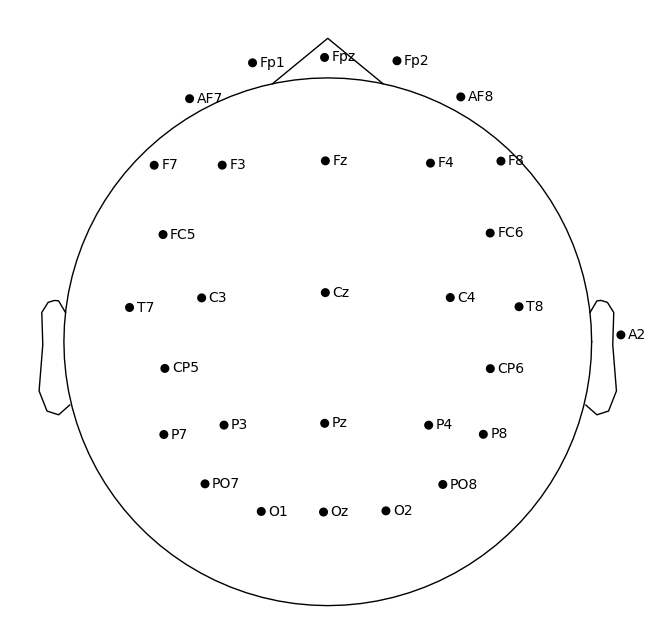

In [12]:
raw.info.set_montage('standard_1020', match_case=False)

# Plot the montage
mne.viz.plot_montage(raw.info.get_montage())

Using matplotlib as 2D backend.


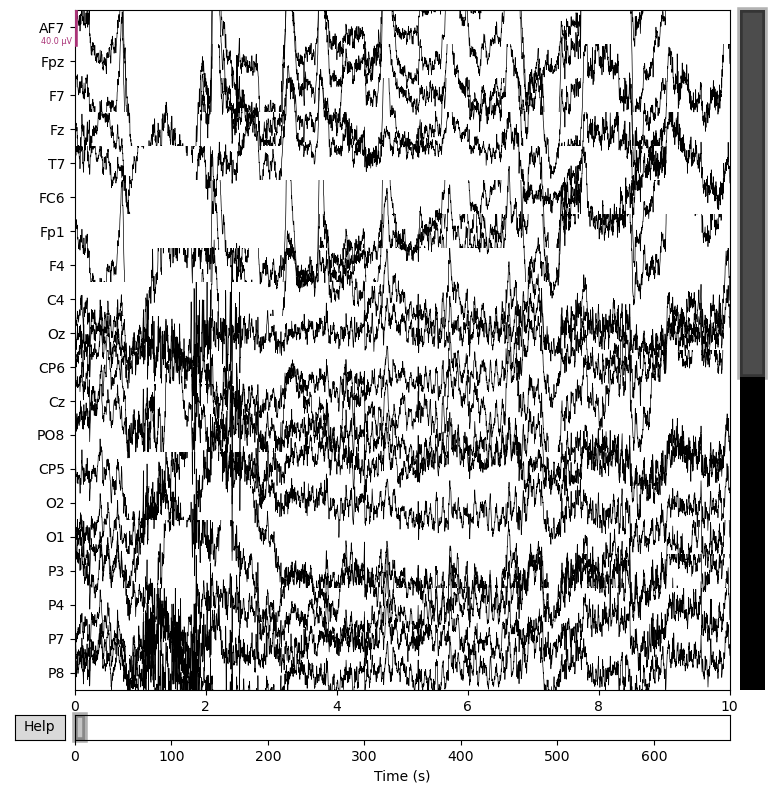

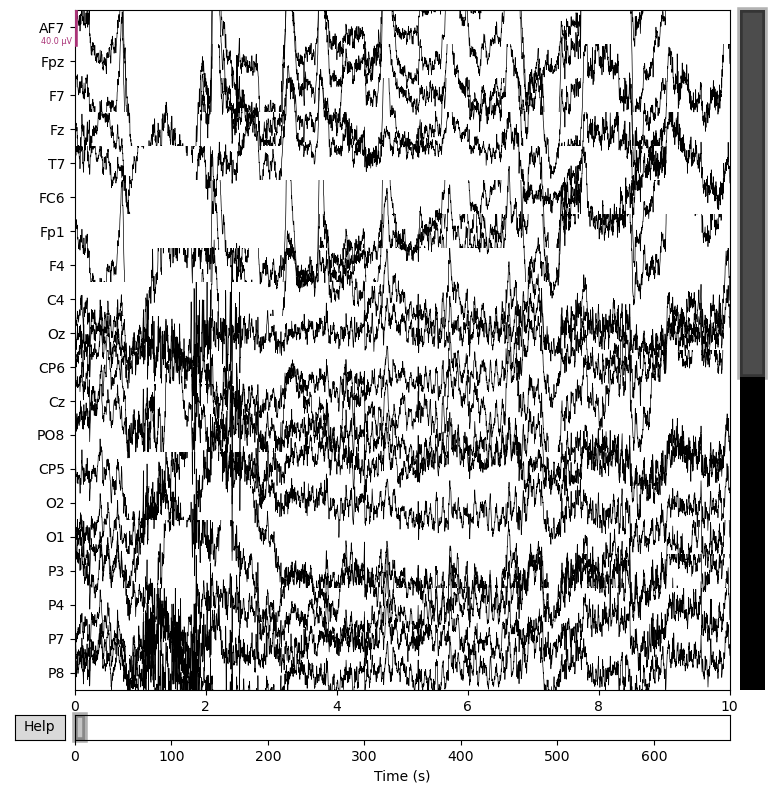

In [13]:
raw.plot()

# Add annotations from MIDI stream

In [14]:
lsl_streams['MIDI']

{'data': array([[  0,  66,   1],
        [  0,  66,  64],
        [  0,  60, 121],
        ...,
        [  0,  55,  64],
        [  0,  75,  95],
        [  0,  75,  64]], dtype=int32),
 'time': array([ 15.37874608,  16.63524483,  26.76071229, ..., 625.60872412,
        625.97964564, 626.51918914])}

In [15]:
midi_q = {}
midi_events = []

for i, msg in enumerate(lsl_streams['MIDI']['data']):
    
    _ = msg[0] # could set this to be note_on or note_off events
    note = msg[1]
    velocity = msg[2]
    
    if not note in midi_q:
        on_t = lsl_streams['MIDI']['time'][i]
        midi_q[note] = {}
        midi_q[note]['onset'] = on_t
        midi_q[note]['velocity'] = velocity
        
    else: # note is already ON
        if velocity == 64: # OFF event
            off_t = lsl_streams['MIDI']['time'][i]
            midi_events.append(
                [
                    midi_q[note]['onset'], # start time
                    off_t - midi_q[note]['onset'], # duration
                    librosa.midi_to_note(note)
                ]
            )
            midi_q.pop(note, None) # remove note from the queue
            
midi_events = np.array(midi_events) # for easier indexing
midi_events

array([['15.378746078000404', '1.2564987561199814', 'F♯4'],
       ['26.76071229064837', '0.7380193946883082', 'C4'],
       ['28.07648038410116', '0.5056933019077405', 'G4'],
       ...,
       ['624.4921949084383', '0.5522632503416389', 'G♯3'],
       ['625.2456768850097', '0.363047237158753', 'G3'],
       ['625.979645641055', '0.5395434950478375', 'D♯5']], dtype='<U32')

In [16]:
lsl_annot = mne.Annotations(
    onset = midi_events[:, 0],
    duration = midi_events[:, 1], # setting durations to 0 to just label event onsets
    description = midi_events[:, 2]
)

raw.set_annotations(lsl_annot)

<RawArray | 37 x 339269 (678.8 s), ~95.8 MB, data loaded>

# Lets find events from annotations

In [17]:
events, event_id = mne.events_from_annotations(raw)

Used Annotations descriptions: ['A3', 'A4', 'A♯3', 'A♯4', 'B3', 'B4', 'C3', 'C4', 'C5', 'C♯3', 'C♯4', 'D3', 'D4', 'D5', 'D♯3', 'D♯4', 'D♯5', 'E3', 'E4', 'E5', 'F3', 'F4', 'F5', 'F♯3', 'F♯4', 'G2', 'G3', 'G4', 'G5', 'G♯2', 'G♯3', 'G♯4']


# Bandpass Filter

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 1651 samples (3.303 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.5s finished


Effective window size : 2.049 (s)


/opt/anaconda3/lib/python3.9/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


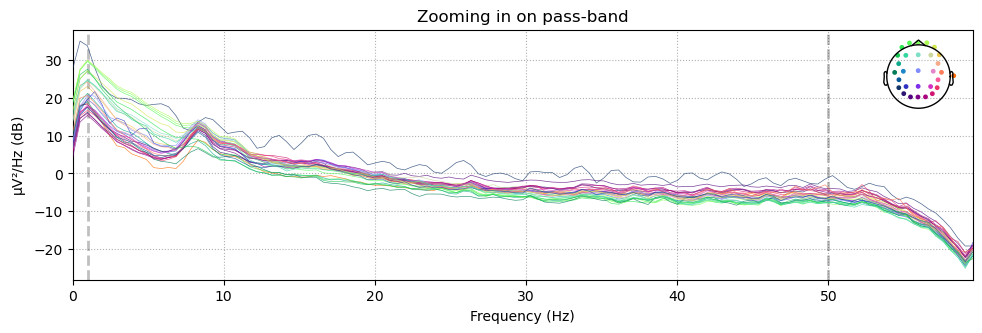

In [18]:
l_freq = 1
h_freq = 50

raw_filt = raw.copy().filter( # make a copy of the array to avoid modifying in place
    l_freq = l_freq, # lower cut-off, in Hz
    h_freq = h_freq, # upper cut-off, in Hz
)


n_fft = 1024

# picks = [''] # a list of channels that you want to focus on, if any
fig = raw_filt.compute_psd(
    # picks= picks,
    fmin = 0, # lower limit to plot
    fmax = 60, # upper limit to plot
    # tmin = 0, # if only using a subset of the data for PSD computation
    # tmax = 10,
    n_fft = n_fft,
).plot()

# Some reformatting if needed
# fig.get_axes()[0].set_ylim(YLIM_MIN, YLIM_MAX)
fig.get_axes()[0].set_title('Zooming in on pass-band')
plt.show()

In [19]:
# Notch filter instead?

if 0:
    # Notch filter
    raw_filt = raw.copy().notch_filter( # make a copy of the array to avoid modifying in place
        freqs = [60, 120, 180, 240]
    )

    # Highpass filter
    raw_filt = raw_filt.filter( # make a copy of the array to avoid modifying in place
        l_freq = 0.1, # lower cut-off, in Hz
        h_freq = None, # upper cut-off, in Hz
    )

    n_fft = 1024

    # picks = [''] # a list of channels that you want to focus on, if any
    raw_filt.compute_psd(
        # picks= picks,
        # fmin = 0, # lower limit to plot
        # fmax = 60, # upper limit to plot
        # tmin = 0, # if only using a subset of the data for PSD computation
        # tmax = 10,
        n_fft = n_fft,
    ).plot()

    plt.show()

# Drop bad channels
(since ERPs showed these channels as suspect)

In [20]:
raw_filt.info.bads = ['P7'] #'Oz', 'O1', , 'Fp2', 'F7', 'P3'] # ideally could label bad segments instead of dropping channels

# Drop bad channels from visual examination before running ICA
raw_filt_drop_bad = raw_filt.copy().drop_channels(raw_filt.info.bads)

# Make Epochs

In [22]:
eps = mne.Epochs(
    raw_filt_drop_bad,
    # raw_filt_drop_bad, 
    # raw,
    picks = ['eeg'],
    events = events, 
    event_id = event_id, 
    tmin=-1,
    tmax= 1,
    baseline=None,
    event_repeated = 'drop',
)

Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
571 matching events found
No baseline correction applied
0 projection items activated


# Get Data for DSS

In [24]:
DSS_data = eps.get_data().T # time x channels x epochs
DSS_data.shape

Using data from preloaded Raw for 571 events and 1001 original time points ...


(1001, 29, 571)

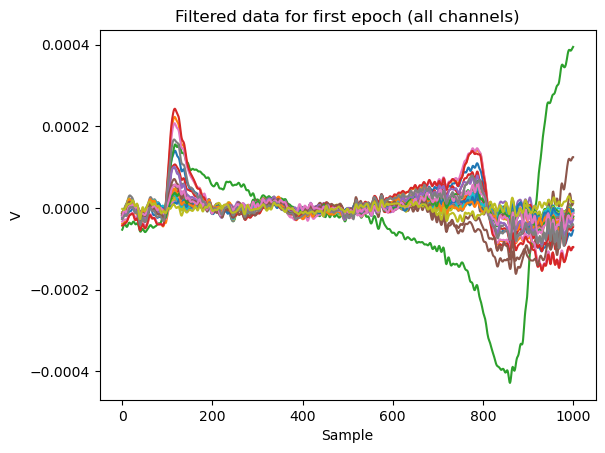

In [27]:
plt.plot(DSS_data[:,:,0]) # plot first epoch
plt.title('Filtered data for first epoch (all channels)')
plt.xlabel('Sample')
plt.ylabel('V')
plt.show()

## Get bias for DSS

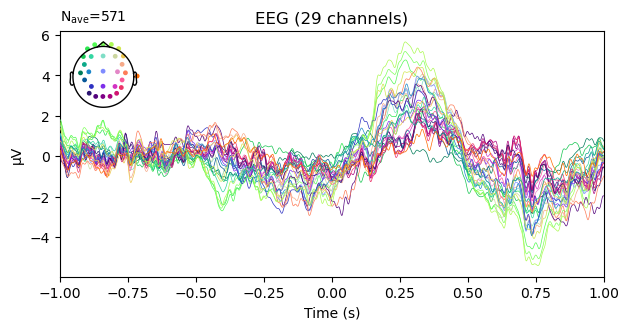

In [28]:
# %matplotlib widget 
eps.average(
    # picks=['Fz', 'Cz', 'Pz', 'Oz', 'C3', 'C4']
).plot()
plt.show()

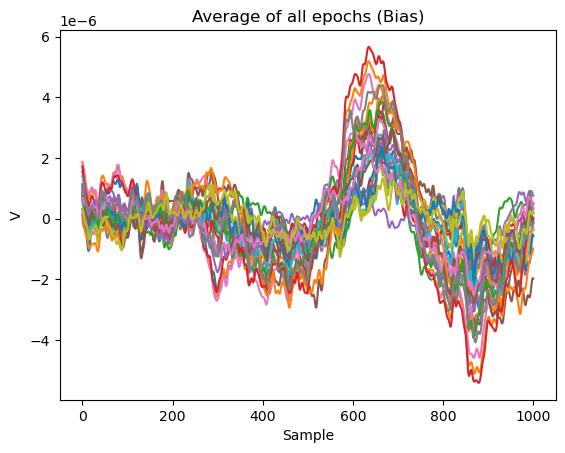

In [30]:
bias_data = eps.average(
    # picks=['Fz', 'Cz', 'Pz', 'Oz', 'C3', 'C4']
)._data.T

# This should be the same as the mne plot abive
plt.figure()
plt.plot(bias_data)
plt.title('Average of all epochs (Bias)')
plt.xlabel('Sample')
plt.ylabel('V')
plt.show()

In [32]:
bias_data.shape # time x channels

(1001, 29)

# Run DSS

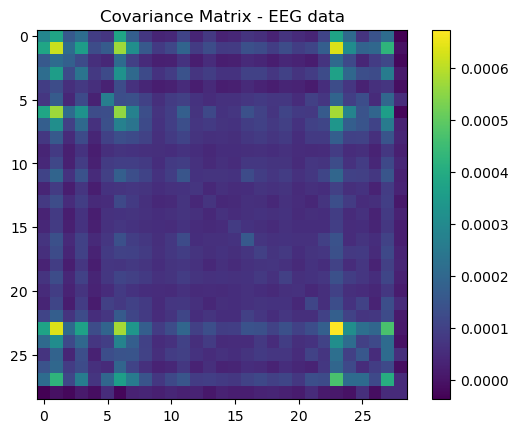

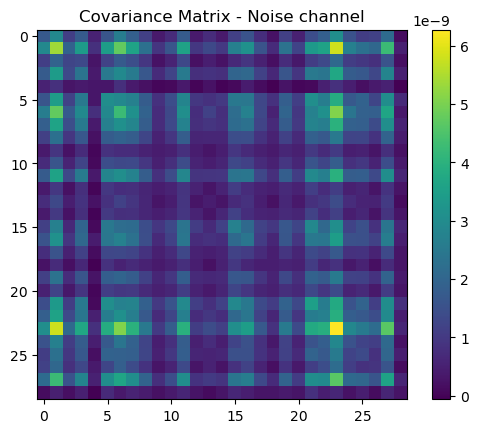

(29, 29)


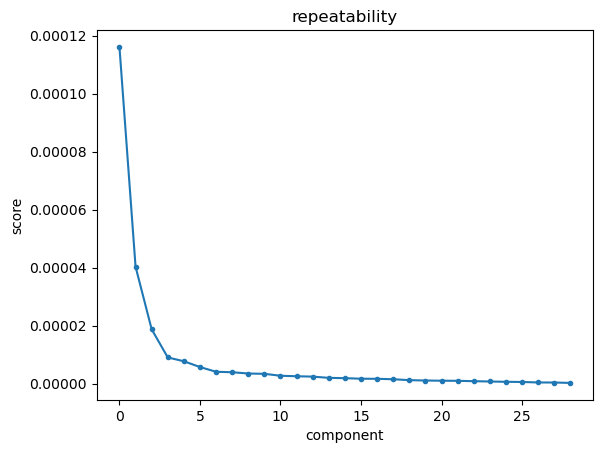

In [33]:
# DSS code from Claire
c0, _ = tscov(DSS_data) #[:,0:nchans,:])
fig = plt.imshow(c0, cmap=None, interpolation=None)
plt.colorbar()
plt.title("Covariance Matrix - EEG data")
plt.show()

# In this case the biased covariance is simply the covariance of the mean over
# trials
c1, _ = tscov(bias_data)
fig = plt.imshow(c1, cmap=None, interpolation=None)
plt.colorbar()
plt.title("Covariance Matrix - Noise channel")
plt.show()

# Apply DSS
[todss, fromdss, pwr0, pwr1] = dss.dss0(c0, c1, keep1=DSS_data.shape[0], keep2=10e-100000)
print(todss.shape)

# plot components explaining variance
plt.figure(30)
plt.clf()
plt.plot(pwr1 / pwr0, '.-')
plt.title('repeatability')
plt.xlabel('component')
plt.ylabel('score')
plt.show()

# which composants to keep?
TOKEEP = [0, 1] #range(2, nchans) #[0] #range(2) #range(nchans-2)

z = fold(np.dot(unfold(DSS_data), todss), epoch_size=DSS_data.shape[0])

best_comp = np.mean(z[:, 0, :], -1)

xx = fold(np.dot(unfold(DSS_data), todss[:, TOKEEP] @ fromdss[TOKEEP, :]), epoch_size=DSS_data.shape[0])

In [34]:
xx.shape

(1001, 29, 571)

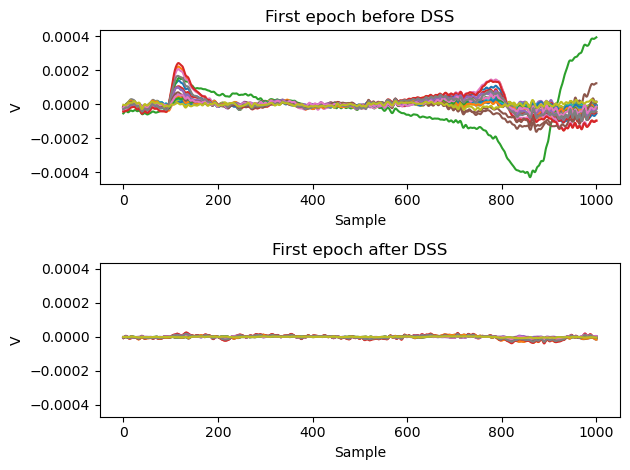

In [36]:
fig, ax = plt.subplots(2,1, sharey=True)

ax[0].plot(DSS_data[:, :, 0])

ax[0].set_title('First epoch before DSS')
ax[0].set_xlabel('Sample')
ax[0].set_ylabel('V')

ax[1].plot(xx[:, :, 0])

ax[1].set_title('First epoch after DSS')
ax[1].set_xlabel('Sample')
ax[1].set_ylabel('V')

plt.tight_layout()
plt.show()

# Normalize the components to compare

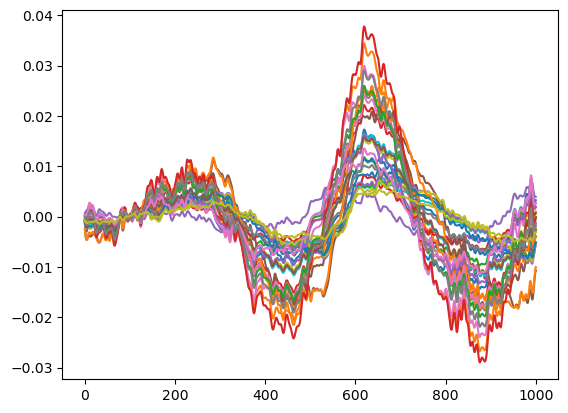

In [38]:
# Not sure why this is not going from -1 to 1?
xx_norm = np.mean(xx, -1)/np.max(np.abs(xx))

plt.plot(xx_norm)
# plt.plot(best_comp_norm, '--', lw=2)
plt.show()

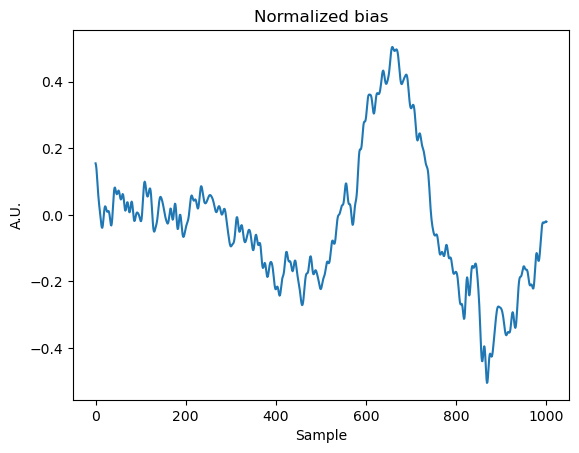

In [41]:
bias_data_norm = np.mean(bias_data, -1)/np.max(np.abs(bias_data))
plt.plot(bias_data_norm)
plt.title('Normalized bias')
plt.xlabel('Sample')
plt.ylabel('A.U.')
plt.show()

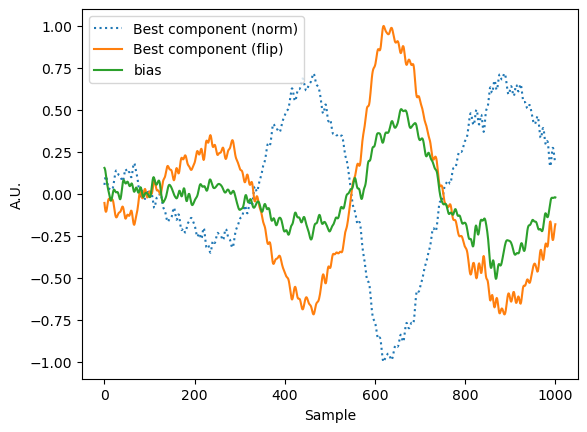

In [44]:
best_comp_norm = best_comp/np.max(np.abs(best_comp))
                                  
plt.plot(best_comp_norm, ':', label = 'Best component (norm)')
plt.plot(-best_comp_norm, label = 'Best component (flip)')
plt.plot(bias_data_norm, label = 'bias')
plt.legend()
plt.xlabel('Sample')
plt.ylabel('A.U.')
plt.show()

https://mne.tools/stable/auto_tutorials/raw/30_annotate_raw.html